In [1]:
import numpy as np
import matplotlib.pyplot as plt
from corner import corner
import emcee
import tqdm_pathos
import precession

/home/sayan/.pyenv/versions/remnantinverse/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(5)

In [4]:
n = 10000
q = np.random.uniform(0, 1, n)
chi1z = np.random.uniform(0, 1, n)
chi2z = np.random.uniform(0, 1, n)
theta1= np.random.uniform(0, np.pi,n)
theta2= np.random.uniform(0, np.pi,n)
deltaphi= np.random.uniform(0, 2*np.pi,n)

In [5]:
def aligned_chif(q, chi1z, chi2z, theta1, theta2, deltaphi):
    
    return compute_chif(
        theta1, theta2, deltaphi, q, chi1z, chi2z,
        )

def compute_chif(theta1, theta2, deltaphi, q, chi1, chi2):

    s1, s2 = precession.get_fixed(q, chi1, chi2)[-2:]
    
    return precession.finalspin(
        theta1, theta2, deltaphi, q, s1, s2,
        )

In [6]:
chif = np.array(tqdm_pathos.starmap(
    aligned_chif, zip(q, chi1z, chi2z, theta1, theta2, deltaphi),
    ))

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8915.42it/s]


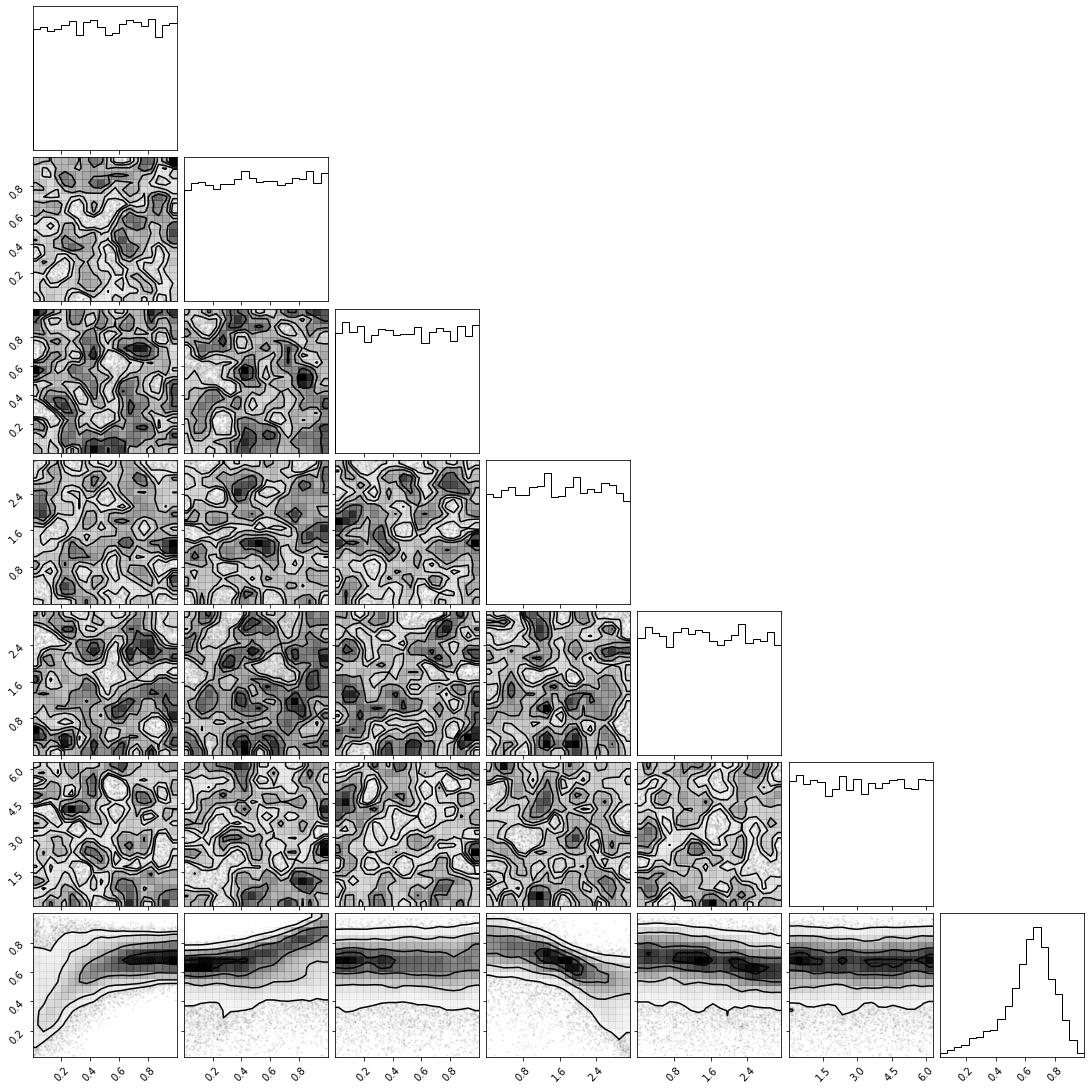

In [9]:
corner(
    np.transpose([q, chi1z, chi2z,theta1, theta2, deltaphi, chif]), smooth=.8
    );

In [16]:
def log_prior(q, chi1z, chi2z, theta1, theta2, deltaphi):
    
    if (0 < q <= 1) and (0 < chi1z < 1) and (0 < chi2z < 1) and (0 <= theta1 <=np.pi) and (0 <= theta2 <= np.pi) and (0<= deltaphi <= 2*np.pi):
        return 0
    return -np.inf

def log_lkl(q, chi1z, chi2z, theta1, theta2, deltaphi, chif):

    diff = np.abs(aligned_chif(q, chi1z, chi2z, theta1, theta2, deltaphi) - chif)

    if diff < .01:
        return diff**2
    return -np.inf
    
def log_prob(x, y):
    
    lp = log_prior(*x)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_lkl(*x, y)

In [17]:
q = .5
chi1z = 0
chi2z = 0
theta1=0
theta2=0
deltaphi=0

chif = aligned_chif(q, chi1z, chi2z, theta1, theta2, deltaphi)
print(chif)

0.6234133461594752


In [18]:
n_dim = 6
n_walkers = 32
p0 = np.random.rand(n_walkers, n_dim)

sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, log_prob, args=[chif],
    )

In [19]:
n_steps = 100000

p0 = np.random.rand(n_walkers, n_dim)
sampler.run_mcmc(p0, n_steps, progress=True);

  0%|                                                                                        | 0/100000 [00:00<?, ?it/s]/home/sayan/.pyenv/versions/remnantinverse/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
 70%|████████████████████████████████████████████████████▏                      | 69512/100000 [02:05<00:56, 539.86it/s]/home/sayan/.pyenv/versions/remnantinverse/lib/python3.10/site-packages/precession/precession.py:4662: RuntimeWarning: invalid value encountered in double_scalars
  chifin = (1./(1.+q)**2.) * ( chi1**2. + (chi2**2.)*(q**4.)  + 2.*chi1*chi2*(q**2.)*costheta12
100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [03:01<00:00, 551.41it/s]


In [95]:
sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [684.86252135 603.21827895 614.91537681]

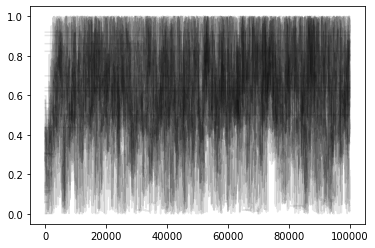

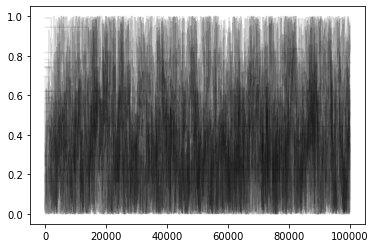

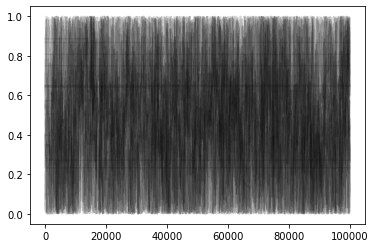

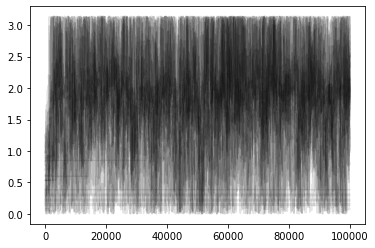

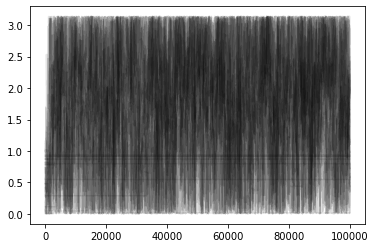

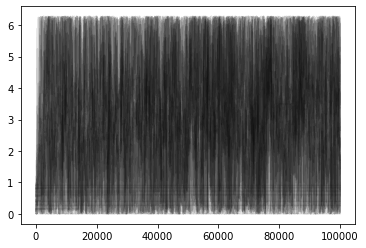

In [20]:
samples = sampler.get_chain()

for i in range(n_dim):
    plt.plot(samples[..., i], 'k', alpha=.1)
    plt.show()

In [21]:
samples = sampler.get_chain(
    #discard=1000, thin=50,
    flat=True,
    )
samples.shape

(3200000, 6)

100%|████████████████████████████████████████████████████████████████████████| 320000/320000 [00:21<00:00, 15081.99it/s]


ValueError: supplied range of [nan, nan] is not finite

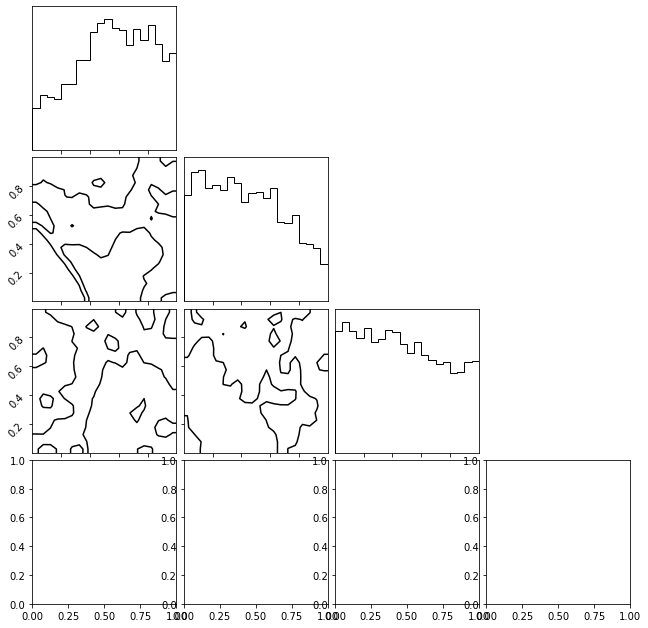

In [98]:
chif_vals = np.array(tqdm_pathos.starmap(
    aligned_chif, zip(*samples.T),
    ))

joint = np.concatenate([samples, chif_vals[:, None]], axis=-1)

corner(
    joint, truths=[q, chi1z, chi2z, chif],
    plot_datapoints=False, plot_density=False,
    levels=[.5, .9], smooth=.8,
    );

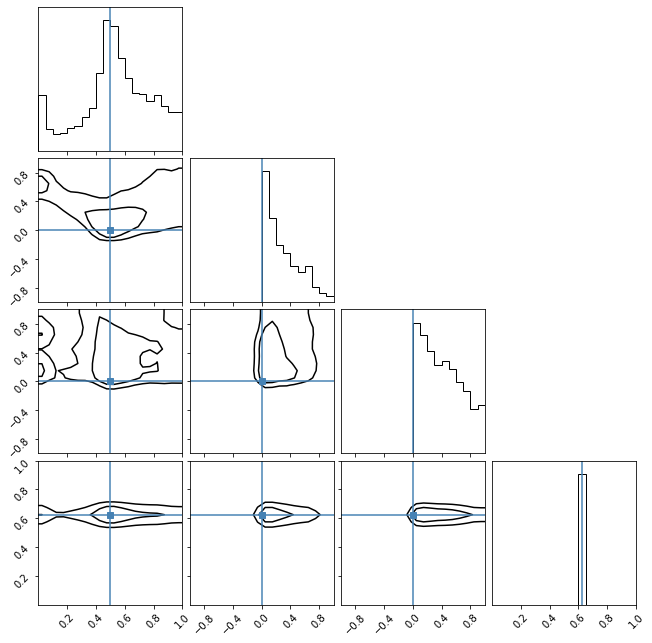

In [99]:
# The sampler should not keep any points with
# |f(q, chi1z, chi2z) - chif| > 0.01
# due to the data-dependent prior.
# For some reason it does, not sure why...?

tol = np.where(np.abs(chif - chif_vals) < .01)

corner(
    joint[tol], truths=[q, chi1z, chi2z, chif],
    range=[[0, 1], [-1, 1], [-1, 1], [0, 1]],
    plot_datapoints=False, plot_density=False,
    levels=[.5, .9], smooth=.8, bins=20,
    );

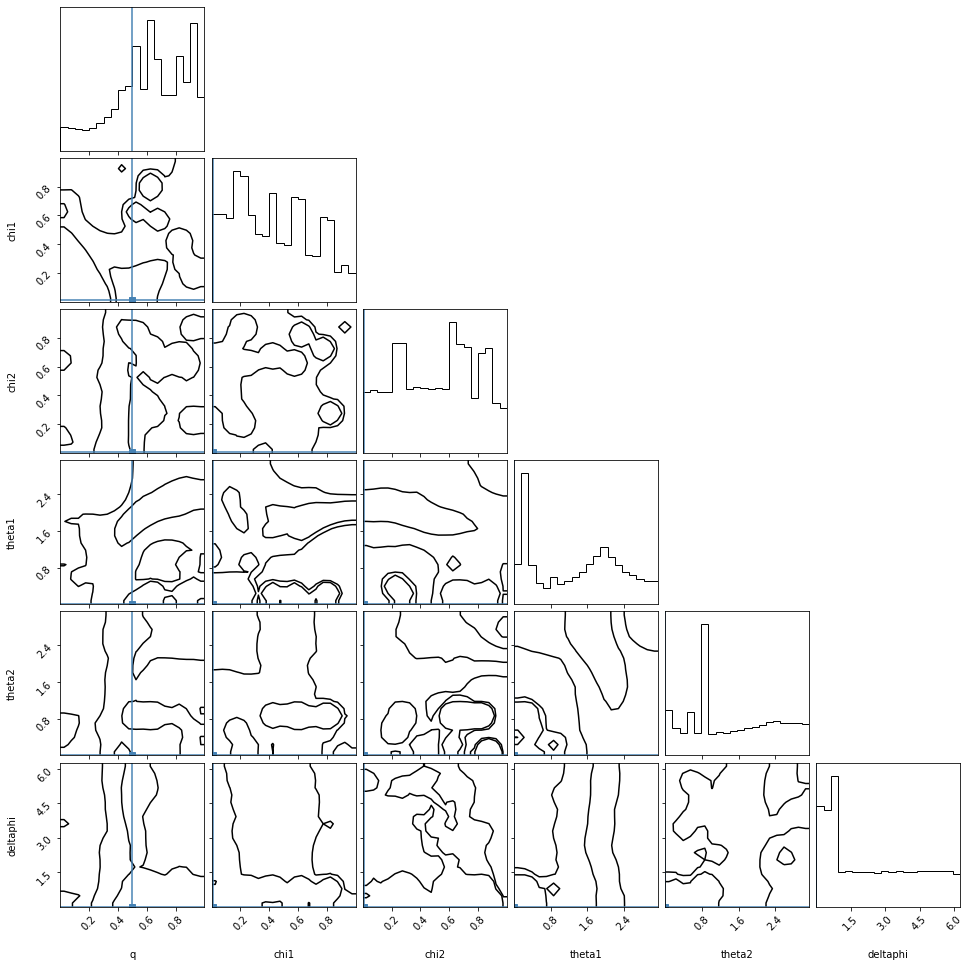

In [23]:
import corner
corner.corner(
    samples, plot_datapoints=False, plot_density=False,
    levels=[.5, .9], smooth=.8, truths=[.5,0.01,0.01, 0, 0, 0], labels=['q','chi1','chi2', 'theta1', 'theta2', 'deltaphi']
    );